[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanhuguet/intro_to_nlp/blob/main/notebooks/06-text-clustering-with-embeddings.ipynb)

In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
try:
    from datasets import load_dataset
except:
    install("datasets")
    from datasets import load_dataset

In [4]:
import pandas as pd

### Load the dataset

In [5]:
dataset = load_dataset("yelp_review_full")

Found cached dataset parquet (/Users/jhuguet/.cache/huggingface/datasets/parquet/yelp_review_full-9c7006f5a2e02666/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

### Convert it to pandas a random sample of 1000 articles

In [6]:
df = pd.DataFrame(dataset["train"].shuffle(42).select(range(100)))

Loading cached shuffled indices for dataset at /Users/jhuguet/.cache/huggingface/datasets/parquet/yelp_review_full-9c7006f5a2e02666/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ac75a2c7407787bc.arrow


## Embedd sentences

In [7]:
try:
    from sentence_transformers import SentenceTransformer
except:
    install("sentence-transformers")
    from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v2", device="mps")

In [9]:
sentence_embedding = model.encode("This is a sentence about cats")

In [10]:
sentence_embedding.shape

(512,)

## Get sentence embeddings for all texts

In [11]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
df["embedding"] = df["text"].progress_apply(model.encode)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.95it/s]


## Let's reduce the dimensionality and visualize the data in 2d

In [13]:
try:
    import umap
except:
    install("umap-learn")
    import umap

In [14]:
def reduce_dimensions(embeddings,
                      n_components=2,
                      n_neighbors=8,
                      random_state = 42):
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine',
                                 n_epochs=10,
                                random_state=random_state)
                            .fit_transform(embeddings))
    df = pd.DataFrame(umap_embeddings, index=embeddings.index)
    return df

In [15]:
embeddings = df["embedding"].apply(pd.Series)

In [16]:
embeddings_2d = reduce_dimensions(embeddings)

In [17]:
embeddings_2d

,0,1
0,4.582953,7.297440
1,7.287442,5.730351
2,4.089309,3.137320
3,5.310508,7.148458
4,7.610355,9.491283
...,...,...
95,5.571242,5.182975
96,7.433656,5.880714
97,3.884577,8.346283
98,7.841904,6.366492


### Let's visualize them...

In [18]:
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

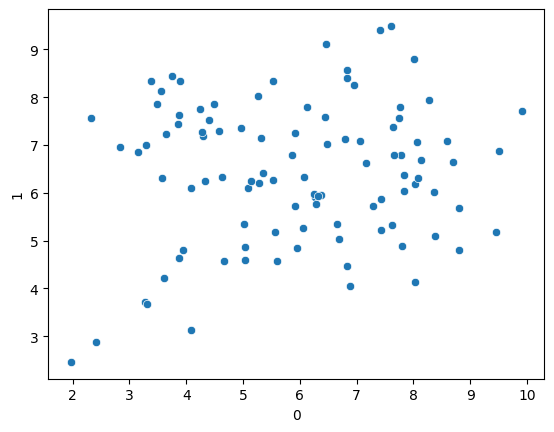

In [19]:
sns.scatterplot(embeddings_2d, x=0, y=1)

Nice, let's see if we can cluster them....

In [20]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
clst = AgglomerativeClustering(n_clusters=10)

In [22]:
clusters = clst.fit_predict(embeddings)

## Let's assign the clusters to the visualization

<Axes: xlabel='0', ylabel='1'>

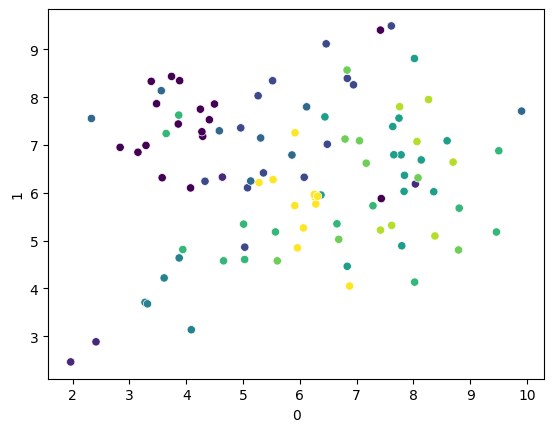

In [23]:
sns.scatterplot(embeddings_2d, x=0, y=1, c=clusters)

## Now, let's review the contents of the clusters...

In [24]:
df["cluster"] = clusters

In [25]:
df.sort_values(by="cluster")

,label,text,embedding,cluster
60,3,I saw Keith Urban and LIttle Big Town recently...,"[-0.020935792, 0.04731756, 0.0023588198, -0.00...",0
30,3,i don't doubt that many people have bad experi...,"[-0.045689143, 0.027873263, 0.045172866, -0.00...",0
79,1,Very Trendy hotel!!! \n\nA friend was able to...,"[-0.026664227, 0.06692223, -0.021216027, -0.02...",0
31,2,This is a fun place to stay when you don't wan...,"[0.027480721, -0.005924307, -0.004701231, 0.00...",0
84,1,Difficult to find. Annoying bar setup with mo...,"[0.034944598, 0.03586732, 0.06934322, -0.02204...",0
...,...,...,...,...
34,0,My wife and I left this evening (Cinco de Mayo...,"[-0.058781028, -0.020392846, -0.006820299, -0....",9
36,2,"For our weekly pizza delivery, we decided to t...","[-0.04530296, 0.048155118, -0.032729574, 0.011...",9
7,0,I went to Sole on the weekend and found that i...,"[-0.0066106534, 0.037963897, 0.041608572, 0.02...",9
85,3,I guess we arrived right after their rush hour...,"[-0.042273503, 0.0513995, 0.047273364, 0.00568...",9


In [26]:
df.loc[df["cluster"] == 9, "text"]

7     I went to Sole on the weekend and found that i...
27    My friend was in the mood for Mexican food so ...
34    My wife and I left this evening (Cinco de Mayo...
36    For our weekly pizza delivery, we decided to t...
70    Breakfast to die for!!!\n\nMy wife and I got i...
71    They weren't busy so the server was on the mon...
73    Came here on a Tues night at 6pm. Warning. If ...
80    I am a big fun of French food and patisserie, ...
85    I guess we arrived right after their rush hour...
90    My wife and I had dinner there last night. It ...
99    Went here with my roommate last week for a lat...
Name: text, dtype: object